# Read in author-provided `AnnData` object

This has the labels they use as well as their UMAP embedding ready-to-go: https://figshare.com/articles/dataset/MS_CSF_h5ad/14356661

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import anndata as ad
import scanpy as sc

/var/folders/5s/r80y6sqj1_g3k78hjd5zlq1r0000gn/T/ipykernel_92653/137524462.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [3]:
adata = ad.read_h5ad('../data/MS_CSF.h5ad')
adata  # The number of genes seem suspiciouslly small
adata.obs['labels'].value_counts()  # Let's remove the doublets, contamination, and RBCs

bad_labels = ['RBC', 'Mono Doublet', 'contamination1', 'B cell doublets', 'doublet']
adata = adata[~adata.obs['labels'].isin(bad_labels), :]

adata  # ~4k cells removed


AnnData object with n_obs × n_vars = 65326 × 10266
    obs: 'labels', 'MS', 'CSF', 'valid_clusters', 'CD4_labels'
    obsm: 'X_umap'

labels
CD4                25105
CD8a               10050
Gran                6313
NK1                 3743
Tregs               3289
CD8n                2924
B1                  2693
RBC                 2333
ncMono              1414
Tdg                 1228
B2                  1191
Mono Doublet        1186
mDC2                 971
Mono                 775
NK2                  679
contamination1       361
pDC                  335
B cell doublets      290
plasma               142
MegaK                113
doublet              105
mDC1                  86
Name: count, dtype: int64

View of AnnData object with n_obs × n_vars = 61051 × 10266
    obs: 'labels', 'MS', 'CSF', 'valid_clusters', 'CD4_labels'
    obsm: 'X_umap'

In [4]:
def ms_filter(adata):
    """Quick helper function because the types are annoying"""
    adata_ms = adata[adata.obs['MS'].astype(str) == 'True'].copy()
    adata_ctrl = adata[adata.obs['MS'].astype(str) == 'False'].copy()
    return adata_ms, adata_ctrl

def csf_filter(adata):
    adata_csf = adata[adata.obs['CSF'].astype(str) == 'True'].copy()
    adata_blood = adata[adata.obs['CSF'].astype(str) == 'False'].copy()
    return adata_csf, adata_blood

adata_ms, adata_ctrl = ms_filter(adata)
adata_csf, adata_blood = csf_filter(adata)
adata_ms.shape
adata_ctrl.shape
adata_csf.shape
adata_blood.shape

(33999, 10266)

(27052, 10266)

(21654, 10266)

(39397, 10266)

# Just a quick reconstruction of their UMAP

/Users/aru/Development/powerhouse-bio-takehome/.venv/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


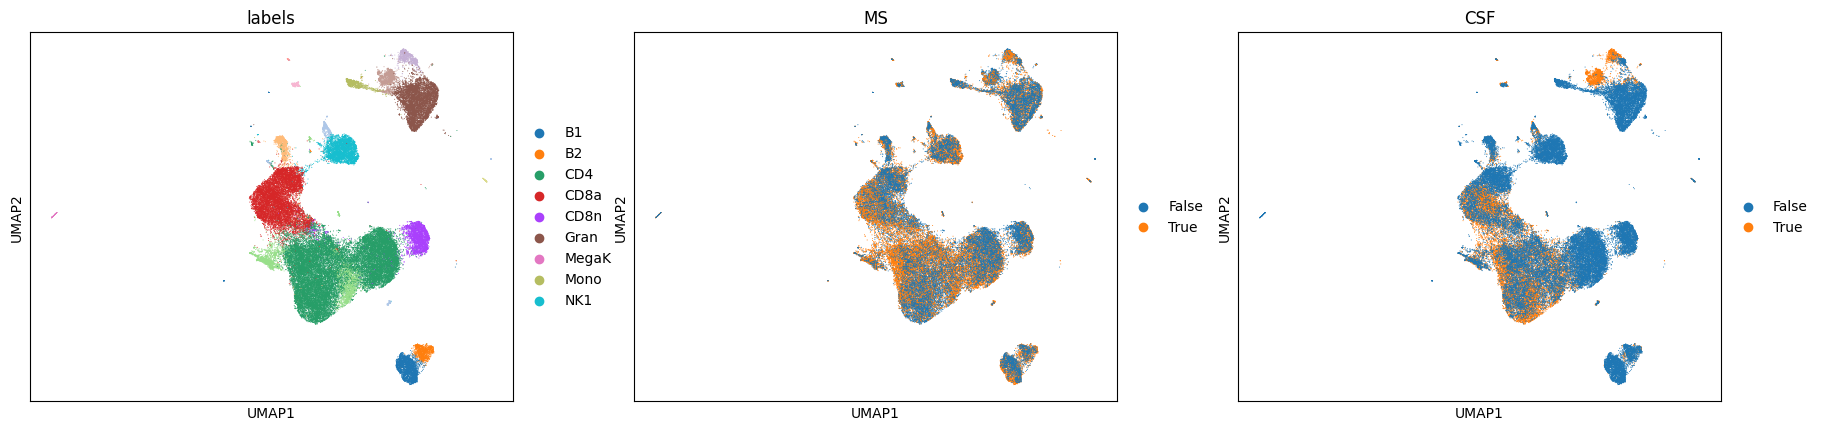

In [5]:
sc.pl.umap(adata, color=['labels', 'MS', 'CSF'])

# Grab curated HPA genes for organelles

In [6]:
def curate_hpa_genes(hpa_path, return_genes=True):
    df = pd.read_csv(hpa_path, delimiter='\t')
    rna_blood_cell_specificity = ['Not detected in immune cells']
    sc_type_distribution_labels = ['Detected in all', 'Detected in many', 'Detected in some']

    blood_cell_mask = ~df['RNA blood cell specificity'].isin(rna_blood_cell_specificity)
    sc_mask = df['RNA single cell type distribution'].isin(sc_type_distribution_labels)

    df = df.loc[blood_cell_mask & sc_mask, :]
    if return_genes:
        return df['Gene'].tolist()
    else:
        return df

pex_genes = curate_hpa_genes('../data/hpa/Peroxisome.tsv')
mt_genes = curate_hpa_genes('../data/hpa/Mitochondria.tsv')
pex_and_mt_genes = set(pex_genes).intersection(mt_genes)
print(f'Number of Peroxisome genes: {len(pex_genes)}')
print(f'Number of Mitochondria genes: {len(mt_genes)}')
print(f'Number of genes in both the Peroxisome and Mitochondria: {len(pex_and_mt_genes)}')

Number of Peroxisome genes: 151
Number of Mitochondria genes: 1630
Number of genes in both the Peroxisome and Mitochondria: 51


# Sanity check: Let's see how many are in `adata`

In [7]:
adata.var_names.isin(pex_genes).sum()  # Not great
adata.var_names.isin(mt_genes).sum()   # Not great
adata.var_names.isin(pex_and_mt_genes).sum()

np.int64(113)

np.int64(1261)

np.int64(39)

I don't like missing 38 Pex genes...

Perhaps most crucially, we are missing a key gene that exists at the interface of the peroxisome and mitochondria, `PPRC1`

Just for good measure, I want to compare this to the AnnData object I made using the 10X table from GEO

In [8]:
adata_geo = ad.read_h5ad('../data/GSE138266.h5ad')
adata_geo  # It seems like they filtered a significant amount of genes
adata_geo.var_names.isin(pex_genes).sum()  # Much better, only 10 missing
adata_geo.var_names.isin(mt_genes).sum()   # Much better

AnnData object with n_obs × n_vars = 814177 × 33694
    obs: 'sample_id', 'donor_id', 'tissue', 'disease', 'sample'
    var: 'gene_ids'

np.int64(141)

np.int64(1504)

# What to do?

It seems non-trivial to treat their 10X data deposit in the same way they did to reproduce their results. We'll go ahead with their uploaded data 

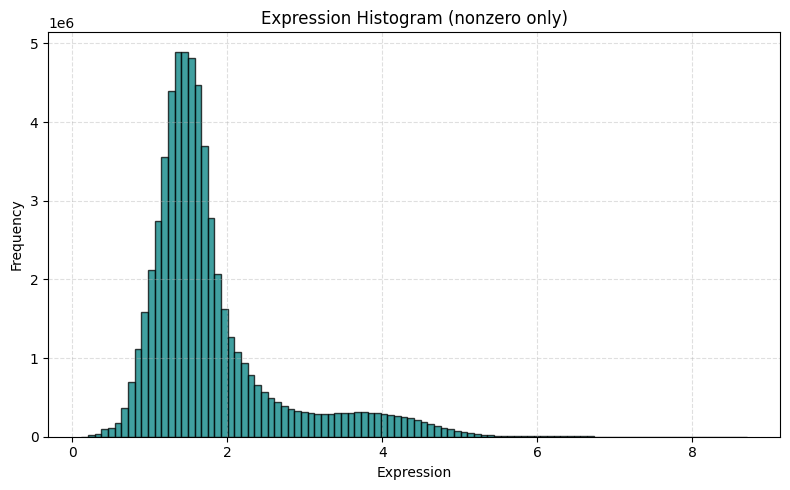

In [9]:
def plot_adata_histogram(adata, bins=100, log=False, title="Expression Histogram (nonzero only)"):
    """
    Plot a histogram of nonzero values in adata.X.

    Parameters
    ----------
    adata : AnnData
        Your AnnData object.
    bins : int
        Number of histogram bins.
    log : bool
        Whether to log-transform the values before plotting.
    title : str
        Title of the plot.
    """
    X = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
    data = X[X > 0]  # exclude zeros

    if log:
        data = np.log1p(data)

    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=bins, color="teal", edgecolor="black", alpha=0.75)
    plt.title(title)
    plt.xlabel("Expression (log1p)" if log else "Expression")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.show()

plot_adata_histogram(adata)

# Read in the supplemental tables

Dataset 4 and 5 are the MS vs. Control for blood and CSF, respectively.

They split it up into upregulated and downregulated sheets.

We will combine everything into one table for convenience.

I believe Group1 = MS, Group2 = Control

In [10]:
def read_supplemental(filepath):
    """Reads both sheets and concatenates them to return a single table."""

    up_df = (
        pd.read_excel(filepath, sheet_name='(a) upregulated')
          .rename({'Unnamed: 0': 'symbol'}, axis=1)
          .assign(direction='up')
    )
    down_df = (
        pd.read_excel(filepath, sheet_name='(b) downregulated')
          .rename({'Unnamed: 0': 'symbol'}, axis=1)
          .assign(direction='down')
    )

    df = pd.concat([up_df, down_df], axis=0)
    return df

blood_filepath = '../data/supplemental/41467_2019_14118_MOESM5_ESM.xlsx'
csf_filepath = '../data/supplemental/41467_2019_14118_MOESM6_ESM.xlsx'

blood_df = read_supplemental(blood_filepath).assign(tissue='blood')
csf_df = read_supplemental(csf_filepath).assign(tissue='csf')

df = pd.concat([blood_df, csf_df])
df

,symbol,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR,direction,tissue
0,AAGAB,1508601.0,3.659198e-198,1.210458,-1.213672,0.040050,0.020750,0.036500,0.020350,CD8a,0.259885,0.558750,-0.144236,9.670371,10.236385,0.140254,2.720939e-29,1.726148e-12,up,blood
1,AAGAB,14892769.0,3.088952e-266,1.015238,-1.016755,0.030950,0.025200,0.030700,0.024950,CD4,0.233974,0.128475,-0.069150,9.243765,6.194203,0.276370,2.979656e-55,1.754951e-17,up,blood
2,AAMP,627076.0,1.629734e-43,1.498697,-1.510910,0.128300,0.079900,0.125200,0.078400,CD8na,0.340119,0.439100,-0.234644,9.186583,1.431951,0.418032,1.257904e-52,3.480925e-02,up,blood
3,AAMP,988210.0,2.859685e-34,1.548936,-1.543107,0.130400,0.097300,0.123850,0.091700,NK1,0.300251,0.288133,-0.109363,9.935232,0.299290,0.693156,5.361843e-23,9.545498e-06,up,blood
4,AAR2,15014089.0,2.478260e-258,1.879590,-1.871433,0.033950,0.024000,0.033300,0.023350,CD4,0.425328,0.325405,-0.100093,9.243484,10.400618,0.160090,2.629221e-139,3.576446e-03,up,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,FAM13A,425111.0,4.087249e-06,-0.534014,0.532056,0.023600,0.062167,0.020833,0.046900,Tregs,-0.353735,-0.721181,0.409663,9.397233,25.796087,0.014703,7.043551e-06,3.578456e-02,down,csf
546,MAL,377068.0,9.299191e-01,-1.336454,1.319772,0.296500,0.431833,0.224233,0.294633,Tregs,-0.363573,-0.151115,0.471019,9.600598,7.759420,0.005982,4.868785e-09,1.769062e-02,down,csf
547,RP5-821D11.7,419855.0,3.913743e-05,-1.046196,1.040356,0.037533,0.078033,0.035800,0.072800,Tregs,-0.440550,-0.608321,0.416219,9.407682,15.376265,0.035630,5.999803e-09,1.177996e-01,down,csf
548,HMBOX1,424119.0,6.374009e-06,-1.883935,1.878435,0.034433,0.066467,0.032700,0.065067,Tregs,-0.442715,-0.517745,0.247942,9.402629,7.548580,0.159822,1.599977e-04,3.925339e-02,down,csf


...what's going on with MYC? The edgeR FDR is super large and the directions change in some of the fold change calculations

In [11]:
df.sort_values(by='fdr_edgeR', ascending=False).dropna(subset='fdr_edgeR').iloc[0, :]

symbol               MYC
stat          17782164.0
pvalue               0.0
bayes1          1.381925
bayes2          -1.37109
mean1             0.4161
mean2           0.348767
nonz1           0.284633
nonz2           0.242333
clusters             CD4
scVI_logFC      0.409336
norm_logFC       0.35991
logFC          -0.899879
logCPM          9.552027
F             116.707147
PValue               0.0
fdr_wil              0.0
fdr_edgeR       0.199966
direction             up
tissue               csf
Name: 1268, dtype: object

scVI_logfc > 0
norm_logFC > 0
logFC < 0 (???)

and fdr_wil vs. fdr_edgeR are wildly different?

Let's go back to the adata and plot a histogram of non-zero values.

array([<Axes: title={'center': 'MYC'}>], dtype=object)

array([<Axes: title={'center': 'MYC'}>], dtype=object)

Text(0.5, 0, 'MYC counts')

Text(0, 0.5, 'Number of cells')

Text(0.5, 1.0, 'MYC expression in CSF CD4 cells')

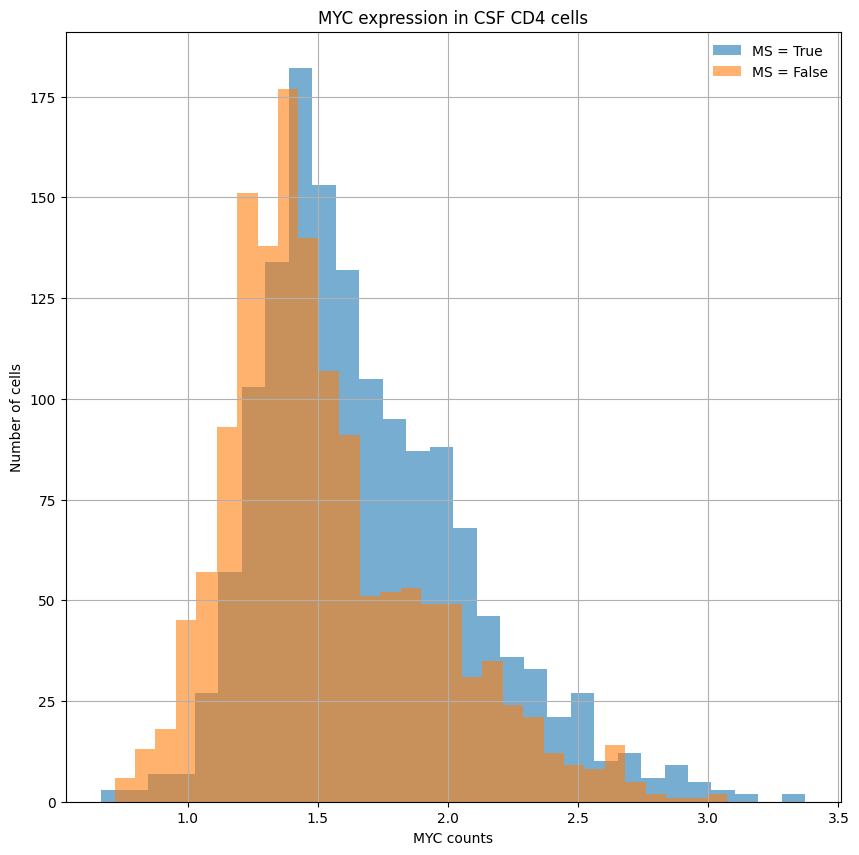

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))

# MS = True
adata[
    (adata.obs['CSF'].astype(str) == "True") \
    & (adata.obs['labels'].astype(str) == 'CD4') \
    & (adata.obs['MS'].astype(str) == "True"), ['MYC']
].to_df().pipe(lambda df: df[df > 0]).dropna() \
 .hist(ax=ax, bins=30, alpha=0.6, label="MS = True")

# MS = False
adata[
    (adata.obs['CSF'].astype(str) == "True") \
    & (adata.obs['labels'].astype(str) == 'CD4') \
    & (adata.obs['MS'].astype(str) == "False"), ['MYC']
].to_df().pipe(lambda df: df[df > 0]).dropna() \
 .hist(ax=ax, bins=30, alpha=0.6, label="MS = False")

ax.set_xlabel("MYC counts")
ax.set_ylabel("Number of cells")
ax.set_title("MYC expression in CSF CD4 cells")
ax.legend(frameon=False)
plt.show()


# ok i can see the complexity

# just filter off edgeR and wil adjP value

unsure how to think about scVI

In [13]:
def fdr_mask(df):
    df = df.copy()
    mask = (df['fdr_wil'] < 0.05) & (df['fdr_edgeR'] < 0.05)
    return df.loc[mask, :]

df_fdr_filt = fdr_mask(df)

df_fdr_filt.head()
df_fdr_filt.shape

degs = df_fdr_filt['symbol'].unique().tolist()

df_fdr_filt['symbol'].value_counts().head(20)  # I just want to see if there are some repeat genes here

count_ranked_genes = df_fdr_filt['symbol'].value_counts().index

df_fdr_filt.set_index('symbol').loc[count_ranked_genes[:5], :].set_index('direction', append=True)

,symbol,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR,direction,tissue
0,AAGAB,1508601.0,3.659198e-198,1.210458,-1.213672,0.04005,0.02075,0.03650,0.02035,CD8a,0.259885,0.558750,-0.144236,9.670371,10.236385,0.140254,2.720939e-29,1.726148e-12,up,blood
1,AAGAB,14892769.0,3.088952e-266,1.015238,-1.016755,0.03095,0.02520,0.03070,0.02495,CD4,0.233974,0.128475,-0.069150,9.243765,6.194203,0.276370,2.979656e-55,1.754951e-17,up,blood
2,AAMP,627076.0,1.629734e-43,1.498697,-1.510910,0.12830,0.07990,0.12520,0.07840,CD8na,0.340119,0.439100,-0.234644,9.186583,1.431951,0.418032,1.257904e-52,3.480925e-02,up,blood
3,AAMP,988210.0,2.859685e-34,1.548936,-1.543107,0.13040,0.09730,0.12385,0.09170,NK1,0.300251,0.288133,-0.109363,9.935232,0.299290,0.693156,5.361843e-23,9.545498e-06,up,blood
4,AAR2,15014089.0,2.478260e-258,1.879590,-1.871433,0.03395,0.02400,0.03330,0.02335,CD4,0.425328,0.325405,-0.100093,9.243484,10.400618,0.160090,2.629221e-139,3.576446e-03,up,blood


(4468, 20)

symbol
PPM1K       12
MTFR1       10
SBDS        10
NDUFS1      10
KLHL42       9
SAYSD1       9
DNAJA1       8
RAD21        8
CAP1         8
RAP1GDS1     8
APEX2        8
TSEN34       8
CCNDBP1      7
AKIRIN1      7
NUDT22       7
TRAF3IP3     7
ZUFSP        7
SRBD1        7
KPNA1        7
RIT1         7
Name: count, dtype: int64

stat         pvalue    bayes1    bayes2     mean1  \
symbol direction                                                            
PPM1K  up          1920187.0  1.960004e-105  4.117767 -4.113968  0.178500   
       up            60649.0   2.385370e-03  1.745719 -1.759955  0.064850   
       up          1011803.0   5.383580e-30  3.903105 -3.889170  0.137300   
       up           692419.0   2.671450e-26  3.421443 -3.416752  0.236250   
       up         18031466.0  2.649951e-100  3.090520 -3.095434  0.198850   
       up          4535837.0   9.186574e-05  1.888672 -1.893060  0.046300   
       up           772093.0   1.986160e-01  2.537599 -2.526284  0.402150   
       up           199267.0   6.358938e-10  1.748124 -1.758359  0.230250   
       up            95818.0   5.616753e-02  2.031140 -2.047907  0.458900   
       up         17319759.0   2.602428e-27  1.356138 -1.352765  0.181467   
       up          2461280.0   3.349207e-18  0.348407 -0.349721  0.234067   
       up           433518.0   6.751476e-08  0.882035 -0.888988  0.221900   
MTFR1  up           893793.0   2.401604e-54  4.858280 -4.848906  0.013550   
       up           657708.0   1.535252e-13  3.656039 -3.665697  0.005100   
       up           524635.0   1.561019e-79  4.215646 -4.212304  0.012350   
       up             8059.0   5.634632e-01  3.493700 -3.510036  0.062800   
       up            60937.0   2.057910e-25  2.992277 -3.003500  0.014400   
       up           166004.0   1.904549e-25  2.544098 -2.555827  0.018800   
       up          4539044.0   7.487667e-05  2.772797 -2.775764  0.011400   
       up         14528881.0  1.154400e-290  3.366344 -3.344613  0.009600   
       up          1431163.0  6.873703e-219  3.218593 -3.212017  0.014200   
       up         17902845.0   3.898014e-46  1.612441 -1.611945  0.013933   
SBDS   down         172448.0   7.768921e-22 -1.526189  1.522212  0.231550   
       down          79566.0   4.103951e-20 -1.667933  1.677340  0.247700   
       down         561584.0   2.869725e-65 -1.616877  1.618180  0.220900   
       down         931900.0   1.135832e-45 -1.508724  1.513721  0.133350   
       down       15215756.0  1.853641e-245 -1.763120  1.759444  0.230150   
       down          56200.0   5.785716e-06 -2.063694  2.063214  0.133350   
       down         593733.0   3.635974e-27 -2.150677  2.150719  0.115850   
       down        4261204.0   7.688245e-01 -2.267860  2.260823  0.064300   
       down          61942.0   2.627917e-24 -2.420377  2.405740  0.234000   
       down        1551633.0  4.283335e-187 -1.437041  1.444717  0.154450   
NDUFS1 up          1585382.0  1.224659e-178  2.472676 -2.486134  0.058100   
       up            60725.0   2.595747e-03  0.934306 -0.930418  0.144200   
       up         15556559.0  1.866563e-224  2.002316 -1.979801  0.065550   
       up           179413.0   2.924973e-18  1.862018 -1.869565  0.099800   
       up           938416.0   2.891211e-44  2.204624 -2.192080  0.060150   
       up           573194.0   4.398198e-61  2.508621 -2.506611  0.064950   
       up           676895.0   2.003249e-10  2.104709 -2.092622  0.047100   
       up         17892428.0   9.371865e-46  1.404006 -1.385630  0.040833   
       up          2209446.0   2.629053e-43  1.470239 -1.463550  0.051267   
       up             5238.0   1.350561e-02  1.586735 -1.575737  0.040800   
KLHL42 up             4405.0   2.872000e-01  2.899951 -2.882768  0.049100   
       up             8264.0   8.067894e-01  2.901570 -2.904491  0.092750   
       up           661844.0   7.861279e-13  3.707631 -3.710372  0.009550   
       up         14909095.0  3.634771e-265  2.559903 -2.567010  0.025350   
       up           174844.0   1.441155e-20  2.246451 -2.256200  0.054800   
       up            82725.0   2.278403e-17  4.243359 -4.287277  0.024450   
       up           907138.0   3.210478e-51  3.270420 -3.282513  0.023000   
       up          4587977.0   2.483580e-06  2.778956 -2.789907  0.026200   
       down       17

<Axes: >

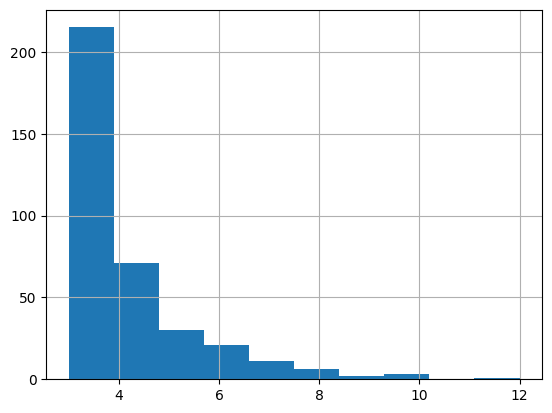

In [14]:
df_fdr_filt['symbol'].value_counts().pipe(lambda df: df[df>2]).hist()

In [15]:
for gene_list in [pex_genes, mt_genes, pex_and_mt_genes]:
    _df = df_fdr_filt.pipe(
        lambda df: df[
            (df['symbol'].isin(gene_list)) & (df['direction'] == 'up')
        ][['symbol', 'direction', 'tissue']]
        .value_counts()
        .reset_index(name='count')
    )
    _df.shape
    _df

(26, 4)

,symbol,direction,tissue,count
0,HSD17B4,up,blood,2
1,AGPS,up,csf,2
2,ATAD1,up,blood,2
3,ECH1,up,blood,2
4,LACC1,up,csf,1
5,TYSND1,up,csf,1
6,TYSND1,up,blood,1
7,TACC1,up,blood,1
8,SCP2,up,blood,1
9,PEX26,up,blood,1


(386, 4)

,symbol,direction,tissue,count
0,MTFR1,up,blood,9
1,PPM1K,up,blood,9
2,NDUFS1,up,blood,7
3,RAP1GDS1,up,blood,7
4,HADHA,up,blood,6
...,...,...,...,...
381,HNRNPLL,up,blood,1
382,HIP1R,up,csf,1
383,HIP1R,up,blood,1
384,HINT3,up,csf,1


(9, 4)

,symbol,direction,tissue,count
0,ATAD1,up,blood,2
1,ECH1,up,blood,2
2,ACSL3,up,blood,1
3,ACSL6,up,blood,1
4,CRAT,up,blood,1
5,ECI2,up,blood,1
6,LACC1,up,csf,1
7,LDHB,up,csf,1
8,NBR1,up,blood,1


In [16]:
df_fdr_filt.pipe(lambda df: df[df['symbol'].isin(['ECH1'])])

,symbol,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR,direction,tissue
630,ECH1,18809863.0,1.470241e-71,1.309204,-1.303218,0.29865,0.2172,0.25825,0.19600,CD4,0.258586,0.287256,-0.019288,9.405212,0.057549,0.810417,1.518498e-245,0.002151,up,blood
631,ECH1,2299225.0,5.713508e-46,1.451805,-1.452117,0.34545,0.2029,0.29540,0.18195,CD8a,0.309260,0.415619,-0.105753,9.835377,0.969038,0.401118,2.655479e-190,0.002010,up,blood


In [17]:
set(pex_genes).intersection(mt_genes)

{'ABCD1',
 'ACAD11',
 'ACOT8',
 'ACSL1',
 'ACSL3',
 'ACSL4',
 'ACSL6',
 'AMACR',
 'ATAD1',
 'CAT',
 'CRAT',
 'CROT',
 'DEPP1',
 'DNM1L',
 'DUT',
 'ECH1',
 'ECI2',
 'FIS1',
 'GNPAT',
 'GPS2',
 'GSTK1',
 'HMGCL',
 'HSDL2',
 'IDH1',
 'IDH2',
 'LACC1',
 'LDHB',
 'LPIN1',
 'MAVS',
 'MDH1',
 'MFF',
 'MPV17',
 'MPV17L',
 'MTARC2',
 'MUL1',
 'NBR1',
 'PDK3',
 'PEX5',
 'PLAAT3',
 'PNPLA8',
 'PPARGC1B',
 'PPRC1',
 'PRDX5',
 'RIDA',
 'SLC25A17',
 'SLC27A2',
 'SOD1',
 'STING1',
 'TANGO2',
 'TMEM135',
 'TMEM41B'}

In [18]:
df_fdr_filt

,symbol,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR,direction,tissue
0,AAGAB,1508601.0,3.659198e-198,1.210458,-1.213672,0.040050,0.020750,0.036500,0.020350,CD8a,0.259885,0.558750,-0.144236,9.670371,10.236385,0.140254,2.720939e-29,1.726148e-12,up,blood
1,AAGAB,14892769.0,3.088952e-266,1.015238,-1.016755,0.030950,0.025200,0.030700,0.024950,CD4,0.233974,0.128475,-0.069150,9.243765,6.194203,0.276370,2.979656e-55,1.754951e-17,up,blood
2,AAMP,627076.0,1.629734e-43,1.498697,-1.510910,0.128300,0.079900,0.125200,0.078400,CD8na,0.340119,0.439100,-0.234644,9.186583,1.431951,0.418032,1.257904e-52,3.480925e-02,up,blood
3,AAMP,988210.0,2.859685e-34,1.548936,-1.543107,0.130400,0.097300,0.123850,0.091700,NK1,0.300251,0.288133,-0.109363,9.935232,0.299290,0.693156,5.361843e-23,9.545498e-06,up,blood
4,AAR2,15014089.0,2.478260e-258,1.879590,-1.871433,0.033950,0.024000,0.033300,0.023350,CD4,0.425328,0.325405,-0.100093,9.243484,10.400618,0.160090,2.629221e-139,3.576446e-03,up,blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,TSPAN15,437913.0,6.207912e-09,-0.698364,0.693353,0.000833,0.004900,0.000833,0.004900,Tregs,-0.352389,-1.333648,0.091001,9.371613,55.815199,0.090560,9.428900e-48,3.932222e-02,down,csf
545,FAM13A,425111.0,4.087249e-06,-0.534014,0.532056,0.023600,0.062167,0.020833,0.046900,Tregs,-0.353735,-0.721181,0.409663,9.397233,25.796087,0.014703,7.043551e-06,3.578456e-02,down,csf
546,MAL,377068.0,9.299191e-01,-1.336454,1.319772,0.296500,0.431833,0.224233,0.294633,Tregs,-0.363573,-0.151115,0.471019,9.600598,7.759420,0.005982,4.868785e-09,1.769062e-02,down,csf
548,HMBOX1,424119.0,6.374009e-06,-1.883935,1.878435,0.034433,0.066467,0.032700,0.065067,Tregs,-0.442715,-0.517745,0.247942,9.402629,7.548580,0.159822,1.599977e-04,3.925339e-02,down,csf


It is interesting that it appears like some of the genes appear across cell type. And their direction is consistent.

Quick Google search shows that many of them are mitochondrial in nature.

Can we find the closest Pex gene?

# Graph functions

- Instantiate graph, simple score_threshold > 700
- Create edge weights
- Shortest path/shortest weighted path

In [19]:
def load_string_graph(
    link_file: Path,
    alias_file: Path,
    score_threshold: int = 700,
) -> nx.Graph:
    """
    Load a STRING protein interaction network as a NetworkX graph using gene symbols as nodes.

    Parameters:
        link_file (Path): Path to STRING links.detailed.v12.0.txt.gz
        alias_file (Path): Path to STRING aliases.v12.0.txt.gz
        score_threshold (int): Minimum combined_score to include an edge.

    Returns:
        networkx.Graph: Undirected graph with gene symbols as nodes.
    """

    # Load alias file
    alias_df = pd.read_csv(alias_file, sep='\t', names=['string_id', 'alias', 'source'])

    # Prioritize HGNC symbols, then Ensembl gene names
    hgnc_map = alias_df[alias_df['source'] == 'Ensembl_HGNC']
    ensembl_map = alias_df[alias_df['source'] == 'Ensembl']

    # Combine with priority: HGNC first, fallback to Ensembl if HGNC not available
    alias_priority = pd.concat([hgnc_map, ensembl_map]).drop_duplicates(subset='string_id', keep='first')
    id_to_symbol = dict(zip(alias_priority['string_id'], alias_priority['alias']))

    # Load interaction data
    links_df = pd.read_csv(link_file, sep=' ')
    links_df['protein1'] = links_df['protein1'].map(id_to_symbol)
    links_df['protein2'] = links_df['protein2'].map(id_to_symbol)

    # Drop any edges where mapping failed
    links_df = links_df.dropna(subset=['protein1', 'protein2'])

    # Filter by confidence threshold
    filtered = links_df[links_df['combined_score'] >= score_threshold]

    # Build the graph
    G = nx.Graph()
    for _, row in filtered.iterrows():
        G.add_edge(
            row['protein1'],
            row['protein2'],
            combined_score=row['combined_score'],
            experimental_score=row['experimental']
        )

    return G

def set_inverse_weights(G: nx.Graph, score_attr='combined_score', weight_attr='weight'):
    """
    Set inverse edge weights so that higher STRING confidence = shorter path.

    Parameters:
        G (nx.Graph): Graph with 'combined_score' as edge attribute.
        score_attr (str): Name of confidence score in edge attributes.
        weight_attr (str): Name of the weight attribute to set.
    """
    for u, v, d in G.edges(data=True):
        score = d.get(score_attr, 0)
        d[weight_attr] = 1_000 / score if score > 0 else float('inf')

def find_shortest_paths_between_sets(G: nx.Graph, source_nodes: list, target_nodes: list) -> dict:
    """
    Find all shortest paths between source and target node sets.

    Parameters:
        G (nx.Graph): The graph.
        source_nodes (list): Source node list (e.g., DEGs).
        target_nodes (list): Target node list (e.g., peroxisome genes).

    Returns:
        dict: { (src, tgt): [path] } for all shortest paths found.
    """
    paths = {}
    for src in source_nodes:
        if src not in G:
            continue
        for tgt in target_nodes:
            if tgt not in G or src == tgt:
                continue
            try:
                path = nx.shortest_path(G, source=src, target=tgt)
                paths[(src, tgt)] = path
            except nx.NetworkXNoPath:
                continue  # Skip if no path exists
    return paths

def build_path_subgraph(G: nx.Graph, paths: dict) -> nx.Graph:
    nodes = set()
    edges = set()
    for path in paths.values():
        nodes.update(path)
        edges.update(zip(path[:-1], path[1:]))
    subG = G.subgraph(nodes).copy()
    return subG

def find_weighted_shortest_paths(G: nx.Graph, source_nodes: list, target_nodes: list, weight='weight') -> dict:
    """
    Find all weighted shortest paths between source and target node sets.

    Parameters:
        G (nx.Graph): The graph.
        source_nodes (list): Source node list (e.g., DEGs).
        target_nodes (list): Target node list (e.g., peroxisome genes).
        weight (str): Edge attribute to use as weight (default: 'weight').

    Returns:
        dict: { (src, tgt): [path] } for all weighted shortest paths found.
    """
    paths = {}
    for src in source_nodes:
        if src not in G:
            continue
        for tgt in target_nodes:
            if tgt not in G or src == tgt:
                continue
            try:
                path = nx.shortest_path(G, source=src, target=tgt, weight=weight)
                paths[(src, tgt)] = path
            except nx.NetworkXNoPath:
                continue
    return paths

In [21]:
STRING_DIR = Path("~/Desktop/databases/STRING").expanduser()
LINK_FILE = STRING_DIR / "9606.protein.links.detailed.v12.0.txt.gz"
ALIAS_FILE = STRING_DIR / "9606.protein.aliases.v12.0.txt.gz"

G = load_string_graph(LINK_FILE, ALIAS_FILE, score_threshold=900)
set_inverse_weights(G)

pex_degs = set(degs).intersection(pex_genes)
mt_degs = set(degs).intersection(mt_genes)
print(f'Number of Pex degs: {len(pex_degs)}')
print(f'Number of Mt degs: {len(mt_degs)}')
weighted_paths = find_weighted_shortest_paths(G, pex_degs, mt_degs)
weighted_paths
# # shortest_paths = find_shortest_paths_between_sets(G, count_ranked_genes[:10], pex_degs)
# # shortest_paths
# # nx.write_graphml(build_path_subgraph(G, shortest_paths), 'shortest_path.graphml')


Number of Pex degs: 29
Number of Mt degs: 376


{('NBR1', 'MRPS21'): ['NBR1', 'RPS27A', 'MRPS7', 'MRPS21'],
 ('NBR1', 'GK'): ['NBR1', 'SQSTM1', 'VDAC1', 'GK'],
 ('NBR1', 'TXNRD2'): ['NBR1', 'RPS27A', 'EEFSEC', 'SEPHS1', 'TXNRD2'],
 ('NBR1', 'MT-ATP6'): ['NBR1', 'RPS27A', 'RPL11', 'MT-ATP6'],
 ('NBR1', 'TRAF3IP3'): ['NBR1', 'SQSTM1', 'TRAF6', 'TRAF3', 'TRAF3IP3'],
 ('NBR1', 'SDHB'): ['NBR1', 'OPTN', 'HTT', 'SDHB'],
 ('NBR1', 'VDAC2'): ['NBR1', 'SQSTM1', 'VDAC1', 'VDAC2'],
 ('NBR1', 'MRPS27'): ['NBR1', 'RPS27A', 'MRPS7', 'MRPS27'],
 ('NBR1', 'UBC'): ['NBR1', 'UBC'],
 ('NBR1', 'VCP'): ['NBR1', 'UBC', 'VCP'],
 ('NBR1', 'MT-ND1'): ['NBR1', 'RPS27A', 'EIF2S1', 'PPP1R15A', 'MT-ND1'],
 ('NBR1', 'NUBPL'): ['NBR1', 'ATG12', 'TUFM', 'NDUFS2', 'NUBPL'],
 ('NBR1', 'MTRF1'): ['NBR1', 'RPS27A', 'BYSL', 'TRMT112', 'HEMK1', 'MTRF1'],
 ('NBR1', 'DDX20'): ['NBR1', 'OPTN', 'HTT', 'AGO2', 'DDX20'],
 ('NBR1', 'SMDT1'): ['NBR1', 'SQSTM1', 'VDAC1', 'MCU', 'SMDT1'],
 ('NBR1', 'HARS2'): ['NBR1', 'GABARAP', 'GPHN', 'GARS1', 'HARS2'],
 ('NBR1', 'PLXNC1'): ['NB

In [28]:
from collections import defaultdict
def tissue_concordance(df):
    return df['tissue'].nunique() == 1

def cell_concordance(df):
    return df['clusters'].nunique() == 1

def filter_by_tissue_and_cell(adata, tissue, cell_type):
    csf, blood = csf_filter(adata)
    if tissue == 'csf':
        ms, ctrl = ms_filter(csf)
    else:
        ms, ctrl = ms_filter(blood)
    ms = ms[ms.obs['labels'] == cell_type, :]
    ctrl = ctrl[ctrl.obs['labels'] == cell_type, :]
    return ms, ctrl

def score_paths(paths, df, adata, length_penalty=1):
    scores = defaultdict(dict)
    for nodes, path in paths.items():
        df_subset = df[df['symbol'].isin(path)].drop_duplicates(subset=['symbol'])
        # Check for tissue/cell concordance
        if not (tissue_concordance(df_subset) and cell_concordance(df_subset)):
            continue
        tissue = df_subset['tissue'].unique().item()
        cell_type = df_subset['clusters'].unique().item()
        degs = df_subset['symbol'].tolist()
        
        # ms_adata, ctrl_adata = filter_by_tissue_and_cell(adata=adata, tissue=tissue, cell_type=cell_type)
        # ms_mean = np.log((ms_adata[:, degs].to_df().apply(np.nanmean)))
        # ctrl_mean = np.log((ctrl_adata[:, degs].to_df().apply(np.nanmean)))
        # strength = ((ms_mean / ctrl_mean).sum())

        scores[nodes] = {
            'score': df_subset.shape[0] / (len(path) ** length_penalty),  # Penalize larger paths
            'path': path,
            'degs': degs,
            'tissue': tissue,
            'cell_type': cell_type,
        }
        # display(df_subset)
    scores = pd.DataFrame(scores).T
    scores.index.names = ['source', 'target']
    return scores

scores = score_paths(weighted_paths, df_fdr_filt, adata=adata, length_penalty=1)
scores

score                                         path  \
source target                                                           
NBR1   ZNF217        0.6      [NBR1, GABARAPL1, SIRT1, HDAC1, ZNF217]   
       OMA1          0.4             [NBR1, SQSTM1, MFN1, OPA1, OMA1]   
       KMO      0.333333          [NBR1, PEX5, AGXT, CBS, KYAT1, KMO]   
       NDUFA8        0.6         [NBR1, SQSTM1, KEAP1, PALB2, NDUFA8]   
       ECH1     0.666667                           [NBR1, PEX5, ECH1]   
...                  ...                                          ...   
ECI2   DHTKD1        0.5                 [ECI2, EHHADH, GCDH, DHTKD1]   
       ALAS1         0.5                 [ECI2, EHHADH, AGXT2, ALAS1]   
       DNAJC19       0.4            [ECI2, HADHB, HADH, AUH, DNAJC19]   
       PLA2G6        0.5  [ECI2, HADHB, SUCLG1, SUCLG2, GNAQ, PLA2G6]   
       DLD           0.5                     [ECI2, ACAT1, DLAT, DLD]   

                                 degs tissue cell_type  
source target                                           
NBR1   ZNF217   [NBR1, SIRT1, ZNF217]  blood       CD4  
       OMA1              [NBR1, OMA1]  blood       CD4  
       KMO                [KMO, NBR1]  blood       CD4  
       NDUFA8   [KEAP1, NBR1, NDUFA8]  blood       CD4  
       ECH1              [ECH1, NBR1]  blood       CD4  
...                               ...    ...       ...  
ECI2   DHTKD1          [DHTKD1, ECI2]  blood      CD8a  
       ALAS1            [ALAS1, ECI2]  blood      CD8a  
       DNAJC19        [DNAJC19, ECI2]  blood      CD8a  
       PLA2G6    [ECI2, GNAQ, PLA2G6]  blood      CD8a  
       DLD                [DLD, ECI2]  blood      CD8a  

[692 rows x 5 columns]

<Axes: >

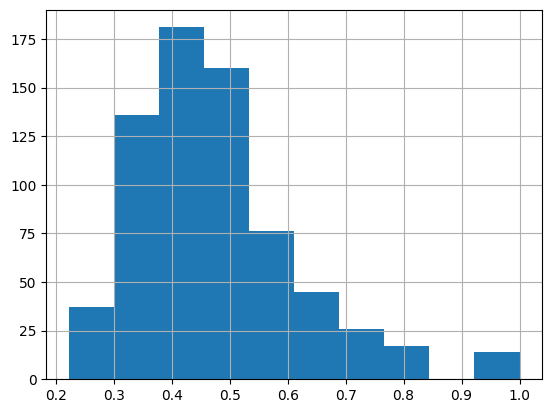

In [32]:
scores.sort_values(by='score', ascending=False)['score'].hist()

# Filter for scores > 0.8

In [54]:

def get_pathway_strength(row):
    ms_adata, ctrl_adata = filter_by_tissue_and_cell(adata, row['tissue'], row['cell_type'])
    degs = row['degs']
    ms_mean = np.log((ms_adata[:, degs].to_df().apply(np.nanmean)))
    ctrl_mean = np.log((ctrl_adata[:, degs].to_df().apply(np.nanmean)))
    strength = ((ms_mean / ctrl_mean).sum())
    return strength

filt_scores = scores.pipe(lambda df: df[df['score'] > 0.7])
filt_scores['pathway_strength'] = filt_scores.apply(get_pathway_strength, axis=1)
filt_scores.to_excel('../data/path_scores.xlsx')

/var/folders/5s/r80y6sqj1_g3k78hjd5zlq1r0000gn/T/ipykernel_92653/1111545400.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filt_scores['pathway_strength'] = filt_scores.apply(get_pathway_strength, axis=1)


In [58]:
filt_scores['degs'].explode().value_counts()

degs
HSD17B4     29
HIBCH       27
CRAT        13
ECH1        11
MRPS16      11
MRPS5       10
MED1         9
SCP2         8
ACOX1        7
TUFM         6
TSFM         5
MRPS27       5
MRPL22       4
DAP3         4
ACAA2        3
ACSS2        3
NBR1         3
AGPS         2
SDHA         2
ACLY         2
MTFMT        2
RNF2         2
ASXL1        2
PEX14        2
GSE1         1
RCOR1        1
ACSL3        1
MTERF3       1
ACSF3        1
MRPS12       1
DDX28        1
UQCR11       1
PDK1         1
PDHB         1
ACSL6        1
MRPL16       1
PPARGC1B     1
Name: count, dtype: int64

In [65]:
def make_cytoscape_pathway_graph(G, path_df, out_path="cytoscape_pathways.gml"):
    """
    Given a graph and a DataFrame with `path` and `pathway_strength`, generate a combined subgraph
    with nodes annotated by average pathway strength and usage count.
    """
    # 1. initialize sets and counters
    all_nodes = set()
    strength_accumulator = defaultdict(list)
    
    # 2. go through each path
    for _, row in path_df.iterrows():
        path_nodes = row['path']
        strength = row['pathway_strength']
        
        for node in path_nodes:
            all_nodes.add(node)
            strength_accumulator[node].append(strength)
    
    # 3. make subgraph
    G_sub = G.subgraph(all_nodes).copy()
    
    # 4. annotate each node
    node_strengths = {
        node: sum(vals)/len(vals) for node, vals in strength_accumulator.items()
    }
    node_counts = {
        node: len(vals) for node, vals in strength_accumulator.items()
    }

    nx.set_node_attributes(G_sub, node_strengths, "avg_pathway_strength")
    nx.set_node_attributes(G_sub, node_counts, "pathway_count")
    nx.set_node_attributes(G_sub, {n: n for n in G_sub.nodes()}, "label")  # for Cytoscape

    # 5. export
    nx.write_gml(G_sub, out_path)
    print(f"Exported Cytoscape graph to: {out_path}")
    
    return G_sub

make_cytoscape_pathway_graph(G, filt_scores)

Exported Cytoscape graph to: cytoscape_pathways.gml


In [71]:
def make_single_pathway_graph(G, path_df, source, target, out_path="single_pathway.graphml"):
    """
    Given a graph and a DataFrame of paths, extract and export a subgraph for a specific (source, target) path.
    The nodes are annotated with pathway_strength.
    """
    # 1. locate the specific row
    row = path_df[
        (path_df['source'] == source) & (path_df['target'] == target)
    ]
    
    if row.empty:
        raise ValueError(f"No path found for source={source}, target={target}")
    
    row = row.iloc[0]
    path_nodes = row['path']
    strength = row['pathway_strength']

    # 2. make subgraph of just the path
    G_sub = G.subgraph(path_nodes).copy()
    
    # 3. annotate
    nx.set_node_attributes(G_sub, {n: float(strength) for n in path_nodes}, "pathway_strength")
    nx.set_node_attributes(G_sub, {n: n for n in path_nodes}, "label")

    nx.write_graphml(G_sub, out_path)
    print(f"Exported single path graph to: {out_path}")
    
    return G_sub

make_single_pathway_graph(G, filt_scores.reset_index(), source='NBR1', target='MTFMT')

Exported single path graph to: single_pathway.graphml


In [75]:
filt_scores.sort_values(by='pathway_strength', ascending=False).head(4)

score                                           path  \
source target                                                            
CRAT   TSFM    0.833333   [CRAT, HSD17B4, EHHADH, HIBCH, MRPS16, TSFM]   
       MRPS27  0.833333  [CRAT, HSD17B4, EHHADH, HIBCH, MRPS5, MRPS27]   
ECH1   TSFM    0.833333   [ECH1, HSD17B4, EHHADH, HIBCH, MRPS16, TSFM]   
       MRPS27  0.833333  [ECH1, HSD17B4, EHHADH, HIBCH, MRPS5, MRPS27]   

                                                degs tissue cell_type  \
source target                                                           
CRAT   TSFM     [CRAT, HIBCH, HSD17B4, MRPS16, TSFM]  blood       CD4   
       MRPS27  [CRAT, HIBCH, HSD17B4, MRPS27, MRPS5]  blood       CD4   
ECH1   TSFM     [ECH1, HIBCH, HSD17B4, MRPS16, TSFM]  blood       CD4   
       MRPS27  [ECH1, HIBCH, HSD17B4, MRPS27, MRPS5]  blood       CD4   

               pathway_strength  
source target                    
CRAT   TSFM            4.254800  
       MRPS27          4.219560  
ECH1   TSFM            4.202602  
       MRPS27          4.167362

In [102]:
# filt_scores.reset_index()['target'].value_counts()
ix = pd.IndexSlice
filt_scores.loc[ix[:, ['MRPS27', 'MRPS16', 'TSFM', 'MRPS5']], :].sort_values(by='pathway_strength', ascending=False).index.get_level_values(0).unique()

Index(['CRAT', 'ECH1', 'HSD17B4', 'SCP2', 'MED1'], dtype='object', name='source')

In [ ]:
def compute_log2fc_from_filtered(adata_ms, adata_ctrl, genes):
    """
    Compute log2 fold change between MS and Ctrl from pre-filtered AnnData.
    
    Inputs:
        - adata_ms: AnnData with only MS cells
        - adata_ctrl: AnnData with only control cells
        - genes: list of gene names
        
    Returns:
        - dict {gene: log2FC}
    """
    expr_ms = adata_ms.to_df()[[g for g in genes if g in adata_ms.var_names]]
    expr_ctrl = adata_ctrl.to_df()[[g for g in genes if g in adata_ctrl.var_names]]

    ms_means = expr_ms.mean()
    ctrl_means = expr_ctrl.mean()

    log2fc = np.log2((ms_means + 1e-8) / (ctrl_means + 1e-8))
    return log2fc.to_dict()

def make_single_pathway_graph(
    G,
    path_df,
    source,
    target,
    adata_ms,
    adata_ctrl,
    out_path=None
):
    """
    Generate a subgraph for a single path with:
      - log2FC between MS and Ctrl (from already filtered AnnData)
      - pathway_strength from path_df
    """
    row = path_df[
        (path_df['source'] == source) & (path_df['target'] == target)
    ]
    if row.empty:
        raise ValueError(f"No path found for source={source}, target={target}")
    
    row = row.iloc[0]
    path_nodes = row['path']
    strength = float(row['pathway_strength'])

    # compute log2fc using pre-filtered MS and Ctrl adata
    log2fc_map = compute_log2fc_from_filtered(adata_ms, adata_ctrl, path_nodes)

    # create subgraph
    G_sub = G.subgraph(path_nodes).copy()

    for node in path_nodes:
        G_sub.nodes[node]['label'] = node
        G_sub.nodes[node]['pathway_strength'] = strength
        G_sub.nodes[node]['log2FC'] = float(log2fc_map.get(node, np.nan))

    if not out_path:
        out_path = f'../data/{source}_{target}.graphml'
    nx.write_graphml(G_sub, out_path)
    print(f"Exported to: {out_path}")
    return G_sub

adata_ms, adata_ctrl = filter_by_tissue_and_cell(adata, tissue="blood", cell_type="CD4")


make_single_pathway_graph(
    G,
    filt_scores.reset_index(),
    source="CRAT",
    target="TSFM",
    adata_ms=adata_ms,
    adata_ctrl=adata_ctrl,
    # out_path="ech1_mrps27_fc.graphml"
)


Exported to: ../data/CRAT_TSFM.graphml


In [86]:
Path('../data/path_scores').mkdir(exist_ok=True)
for idx, row in filt_scores.iterrows():
    source = idx[0]
    target = idx[1]
    tissue = row['tissue']
    cell_type = row['cell_type']
    adata_ms, adata_ctrl = filter_by_tissue_and_cell(adata, tissue=tissue, cell_type=cell_type)
    make_single_pathway_graph(
        G,
        filt_scores.reset_index(),
        source=source,
        target=target,
        adata_ms=adata_ms,
        adata_ctrl=adata_ctrl,
        out_path=f'../data/path_scores/{source}_{target}.graphml'
    )
    

Exported to: ../data/path_scores/NBR1_MTFMT.graphml


Exported to: ../data/path_scores/NBR1_CRAT.graphml


Exported to: ../data/path_scores/PEX14_ACSS2.graphml


Exported to: ../data/path_scores/PEX14_ACAA2.graphml


Exported to: ../data/path_scores/HSD17B4_MRPS27.graphml


Exported to: ../data/path_scores/HSD17B4_MRPS16.graphml


Exported to: ../data/path_scores/HSD17B4_ECH1.graphml


Exported to: ../data/path_scores/HSD17B4_TUFM.graphml


Exported to: ../data/path_scores/HSD17B4_TSFM.graphml


Exported to: ../data/path_scores/HSD17B4_MRPS5.graphml


Exported to: ../data/path_scores/HSD17B4_MRPL22.graphml


Exported to: ../data/path_scores/HSD17B4_CRAT.graphml


Exported to: ../data/path_scores/HSD17B4_DAP3.graphml


Exported to: ../data/path_scores/ASXL1_MRPS12.graphml


Exported to: ../data/path_scores/ASXL1_MRPL16.graphml


Exported to: ../data/path_scores/AGPS_ACSS2.graphml


Exported to: ../data/path_scores/AGPS_ACAA2.graphml


Exported to: ../data/path_scores/ECH1_MRPS27.graphml


Exported to: ../data/path_scores/ECH1_MRPS16.graphml


Exported to: ../data/path_scores/ECH1_TSFM.graphml


Exported to: ../data/path_scores/ECH1_MRPS5.graphml


Exported to: ../data/path_scores/ECH1_MRPL22.graphml


Exported to: ../data/path_scores/ECH1_HIBCH.graphml


Exported to: ../data/path_scores/ECH1_CRAT.graphml


Exported to: ../data/path_scores/ECH1_DAP3.graphml


Exported to: ../data/path_scores/ACSL6_SDHA.graphml


Exported to: ../data/path_scores/CRAT_NBR1.graphml


Exported to: ../data/path_scores/CRAT_MRPS27.graphml


Exported to: ../data/path_scores/CRAT_MRPS16.graphml


Exported to: ../data/path_scores/CRAT_ECH1.graphml


Exported to: ../data/path_scores/CRAT_TSFM.graphml


Exported to: ../data/path_scores/CRAT_MRPS5.graphml


Exported to: ../data/path_scores/CRAT_MRPL22.graphml


Exported to: ../data/path_scores/CRAT_HIBCH.graphml


Exported to: ../data/path_scores/CRAT_DAP3.graphml


Exported to: ../data/path_scores/ACOX1_ACSS2.graphml


Exported to: ../data/path_scores/ACOX1_ACAA2.graphml


Exported to: ../data/path_scores/ACOX1_PDK1.graphml


Exported to: ../data/path_scores/MED1_MRPS27.graphml


Exported to: ../data/path_scores/MED1_MRPS16.graphml


Exported to: ../data/path_scores/MED1_TUFM.graphml


Exported to: ../data/path_scores/MED1_TSFM.graphml


Exported to: ../data/path_scores/MED1_MRPS5.graphml


Exported to: ../data/path_scores/MED1_UQCR11.graphml


Exported to: ../data/path_scores/MED1_MTERF3.graphml


Exported to: ../data/path_scores/MED1_MTFMT.graphml


Exported to: ../data/path_scores/MED1_ACSF3.graphml


Exported to: ../data/path_scores/SCP2_MRPS27.graphml


Exported to: ../data/path_scores/SCP2_MRPS16.graphml


Exported to: ../data/path_scores/SCP2_ECH1.graphml


Exported to: ../data/path_scores/SCP2_TSFM.graphml


Exported to: ../data/path_scores/SCP2_MRPS5.graphml


Exported to: ../data/path_scores/SCP2_MRPL22.graphml


Exported to: ../data/path_scores/SCP2_CRAT.graphml


Exported to: ../data/path_scores/SCP2_DAP3.graphml


Exported to: ../data/path_scores/ACSL3_SDHA.graphml


Exported to: ../data/path_scores/PPARGC1B_GSE1.graphml


In [88]:
results_filt

NameError: name 'results_filt' is not defined

In [156]:
adata_blood, adata_csf = csf_filter(adata)
blood_adata_ms, blood_adata_ctrl = ms_filter(adata_blood)

blood_adata_ms[blood_adata_ms.obs['labels'] == 'CD8a', ['CALR', 'NBR1', 'P4HA1']].to_df().apply(np.nanmean)
blood_adata_ctrl[blood_adata_ctrl.obs['labels'] == 'CD8a', ['CALR', 'NBR1', 'P4HA1']].to_df().apply(np.nanmean)

CALR     0.728462
NBR1     0.121112
P4HA1    0.033041
dtype: float32

CALR     0.560473
NBR1     0.107121
P4HA1    0.028088
dtype: float32

In [112]:
scores.reset_index().groupby('source').agg({'score': np.mean}).sort_values(by='score', ascending=False)

/var/folders/5s/r80y6sqj1_g3k78hjd5zlq1r0000gn/T/ipykernel_87800/2193915748.py:1: FutureWarning: The provided callable <function mean at 0x10781b160> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  scores.reset_index().groupby('source').agg({'score': np.mean}).sort_values(by='score', ascending=False)


,score
source,
MED1,0.39489
PPARGC1B,0.386169
VIM,0.383583
ACAA1,0.370197
NBR1,0.360736
CRAT,0.357295
IDI1,0.357189
ASXL1,0.353995
SCP2,0.336898


In [98]:
df_fdr_filt.pipe(lambda df: df[df['symbol'].isin(pex_genes)])
# pex_genes

,symbol,stat,pvalue,bayes1,bayes2,mean1,mean2,nonz1,nonz2,clusters,scVI_logFC,norm_logFC,logFC,logCPM,F,PValue,fdr_wil,fdr_edgeR,direction,tissue
18,ACAA1,186532.0,5.900718e-15,1.058166,-1.066234,0.151500,0.096100,0.129900,0.081300,Tregs,0.338370,0.351495,-0.382529,9.203776,3.114274,3.138638e-01,1.604943e-28,7.450530e-03,up,blood
27,ACSL3,15344237.0,1.982222e-237,3.955353,-3.952536,0.044100,0.021750,0.042750,0.021200,CD4,0.685503,0.672037,-0.202109,9.248093,36.442382,4.931640e-03,4.380338e-200,3.651241e-02,up,blood
30,ACSL6,15856299.0,9.152757e-207,1.290383,-1.296990,0.078950,0.052450,0.074600,0.049950,CD4,0.308684,0.337471,-0.182490,9.271023,13.028193,3.195200e-02,7.772425e-264,1.499992e-02,up,blood
208,ASXL1,1546573.0,2.222934e-188,0.683162,-0.684561,0.053350,0.033650,0.050750,0.031800,CD8a,0.192779,0.359952,-0.008961,9.676848,0.268337,8.002450e-01,2.223814e-88,8.051673e-07,up,blood
209,ASXL2,4664603.0,4.035394e-09,2.558283,-2.553615,0.089550,0.053000,0.083800,0.050150,Gran,0.493368,0.700192,-0.159907,9.299813,1.904455,4.119736e-01,2.645578e-39,1.170959e-04,up,blood
210,ATAD1,16088907.0,1.533667e-193,4.093442,-4.113715,0.075650,0.033750,0.073700,0.033250,CD4,0.828207,0.808424,-0.513206,9.265784,114.809902,1.876826e-09,6.317717e-190,9.883578e-09,up,blood
211,ATAD1,1689939.0,1.080502e-153,3.564936,-3.533280,0.078300,0.024500,0.075800,0.024100,CD8a,0.751005,1.014208,-0.445641,9.686554,43.619907,3.180597e-04,8.680579e-110,6.603015e-04,up,blood
486,CRAT,14656565.0,5.708273e-282,1.817418,-1.815489,0.013950,0.006100,0.013750,0.006100,CD4,0.637944,0.862710,-0.050115,9.230695,11.453247,3.210472e-01,2.020919e-217,2.380120e-03,up,blood
630,ECH1,18809863.0,1.470241e-71,1.309204,-1.303218,0.298650,0.217200,0.258250,0.196000,CD4,0.258586,0.287256,-0.019288,9.405212,0.057549,8.104168e-01,1.518498e-245,2.150550e-03,up,blood
631,ECH1,2299225.0,5.713508e-46,1.451805,-1.452117,0.345450,0.202900,0.295400,0.181950,CD8a,0.309260,0.415619,-0.105753,9.835377,0.969038,4.011179e-01,2.655479e-190,2.010469e-03,up,blood


In [101]:
np.log((0.15150 - 0.096100) / (0.15150 + 0.096100))

np.float64(-1.497234947057203)

# Load in STRING graph

Filter for score >= 700

In [ ]:
def load_string_graph(
    link_file: Path,
    alias_file: Path,
    score_threshold: int = 700,
) -> nx.Graph:
    """
    Load a STRING protein interaction network as a NetworkX graph using gene symbols as nodes.

    Parameters:
        link_file (Path): Path to STRING links.detailed.v12.0.txt.gz
        alias_file (Path): Path to STRING aliases.v12.0.txt.gz
        score_threshold (int): Minimum combined_score to include an edge.

    Returns:
        networkx.Graph: Undirected graph with gene symbols as nodes.
    """

    # Load alias file
    alias_df = pd.read_csv(alias_file, sep='\t', names=['string_id', 'alias', 'source'])

    # Prioritize HGNC symbols, then Ensembl gene names
    hgnc_map = alias_df[alias_df['source'] == 'Ensembl_HGNC']
    ensembl_map = alias_df[alias_df['source'] == 'Ensembl']

    # Combine with priority: HGNC first, fallback to Ensembl if HGNC not available
    alias_priority = pd.concat([hgnc_map, ensembl_map]).drop_duplicates(subset='string_id', keep='first')
    id_to_symbol = dict(zip(alias_priority['string_id'], alias_priority['alias']))

    # Load interaction data
    links_df = pd.read_csv(link_file, sep=' ')
    links_df['protein1'] = links_df['protein1'].map(id_to_symbol)
    links_df['protein2'] = links_df['protein2'].map(id_to_symbol)

    # Drop any edges where mapping failed
    links_df = links_df.dropna(subset=['protein1', 'protein2'])

    # Filter by confidence threshold
    filtered = links_df[links_df['combined_score'] >= score_threshold]

    # Build the graph
    G = nx.Graph()
    for _, row in filtered.iterrows():
        G.add_edge(
            row['protein1'],
            row['protein2'],
            combined_score=row['combined_score'],
            experimental_score=row['experimental']
        )

    return G

In [ ]:

STRING_DIR = Path("~/Desktop/databases/STRING").expanduser()
LINK_FILE = STRING_DIR / "9606.protein.links.detailed.v12.0.txt.gz"
ALIAS_FILE = STRING_DIR / "9606.protein.aliases.v12.0.txt.gz"

G = load_string_graph(LINK_FILE, ALIAS_FILE)
G

In [ ]:
genes = df_fdr_filt['symbol'].tolist()
G_sub = G.subgraph(genes)
nx.draw_networkx(G_sub)

In [ ]:
def draw_highlighted_graph(
    G: nx.Graph,
    highlight_nodes: list,
    node_size: int = 300,
    figsize=(10, 10),
    layout_seed: int = 42
):
    """
    Draw a graph with specific nodes highlighted in red.

    Parameters:
        G (nx.Graph): The graph to draw.
        highlight_nodes (list): List of nodes to highlight in red.
        node_size (int): Size of the nodes.
        figsize (tuple): Size of the figure.
        layout_seed (int): Seed for layout reproducibility.
    """
    pos = nx.spring_layout(G, seed=layout_seed)
    plt.figure(figsize=figsize)

    node_colors = ['red' if n in highlight_nodes else 'lightgray' for n in G.nodes]
    nx.draw(
        G, pos,
        node_color=node_colors,
        with_labels=True,
        node_size=node_size,
        edge_color='gray',
        font_size=8
    )
    plt.title("Highlighted Subgraph")
    plt.axis('off')
    plt.show()

draw_highlighted_graph(G_sub, highlight_nodes=pex_genes)


In [182]:
def get_neighbor_subgraph(G: nx.Graph, gene_list: list, include_query_nodes: bool = False) -> nx.Graph:
    """
    Return a subgraph of G induced by neighbors of the input genes.

    Parameters:
        G (nx.Graph): The full graph.
        gene_list (list): List of genes to query.
        include_query_nodes (bool): If True, include the original genes in the subgraph.

    Returns:
        nx.Graph: Subgraph induced by neighbors of the gene list.
    """
    neighbors = set()
    for gene in gene_list:
        if gene in G:
            neighbors.update(G.neighbors(gene))

    if include_query_nodes:
        neighbors.update(gene_list)

    return G.subgraph(neighbors).copy()

G_pex = get_neighbor_subgraph(G, gene_list=pex_genes)
nx.write_graphml(G_pex, 'G_pex.graphml')

In [ ]:
G_pex = G.subgraph(pex_genes)
nx.write_graphml(G_pex, 'G_pex.graphml')

deg_genes = df_fdr_filt['symbol'].tolist()
highlight_nodes = set(G_pex.nodes()).intersection(deg_genes)
draw_highlighted_graph(G_sub, highlight_nodes=highlight_nodes)

# alright let's address the problem

we have:

- differentially expressed genes for each cell type

Deliverables
1. Code
We’ll work with Jupyter notebook and Python. Your code should be well-organized, readable,
and reproducible. Please include comments or docstrings where appropriate, and ensure to
reference sources where appropriate.

2. Report
Please submit a brief write-up (as Markdown or PDF) covering:
    
    ● Your overall approach and rationale
    ● Your strategy for integrating expression and network information
    ● How you prioritized novel candidate genes
    ● Limitations, assumptions, or areas for improvement

● Optional: visualizations of networks, scores, or top candidates

3. Outputs
    
    ● A table of ranked candidate genes with associated scores and interpretation
    ● Any plots or visualizations you used to support your conclusions

Submission
Please provide:
    
    ● Your code (in a folder or GitHub repo)
    ● Your report (PDF or Markdown)
    ● Any output files (e.g. results tables, visualizations)

# Let's get in the STRING network

In [ ]:
from stringutils import (
    load_string_network,
    load_alias_map,
    map_genes_to_string_ids,
    subset_graph,
    annotate_colors,
    relabel_graph_nodes,
    draw_colored_graph
)

# Step 1: Load network and alias map
G_full = load_string_network(score_threshold=700)
alias_df = load_alias_map()

# Step 2: Load your gene lists
pex_genes = pd.read_csv('../data/hpa/Peroxisome.tsv', sep='\t')['Gene'].tolist()

mt_hpa = pd.read_csv('../data/hpa/Mitochondria.tsv', sep='\t')
mt_hpa = mt_hpa.dropna(subset=['Subcellular location', 'Molecular function'])
mt_hpa = mt_hpa[mt_hpa['RNA blood cell distribution'].isin(['Detected in all', 'Detected in many', 'Detected in some'])]
mt_genes = mt_hpa['Gene'].tolist()

# Step 3: Map genes to STRING IDs
pex_to_str, str_to_pex = map_genes_to_string_ids(pex_genes, alias_df)
mt_to_str, str_to_mt = map_genes_to_string_ids(mt_genes, alias_df)

# Step 4: Subset the graph to neighborhood of genes
G_sub = subset_graph(
    G_full,
    gene_list=list(pex_to_str.keys()) + list(mt_to_str.keys()),
    symbol_to_string={**pex_to_str, **mt_to_str},
    distance=1
)

# Step 5: Annotate and relabel
G_sub = annotate_colors(G_sub, pex_to_str, mt_to_str)
G_sub = relabel_graph_nodes(G_sub, alias_df)

# Step 6: Plot
draw_colored_graph(G_sub, title="STRING: Mitochondria vs Peroxisomes")


In [ ]:
df_fdr_filt['symbol'].value_counts().head(20)

df_fdr_filt['symbol'].value_counts().pipe(lambda df: df[df>2]).hist()

In [ ]:
G_full.nodes()

# let's pick cell types that are known to have a lot of peroxisomes

In [ ]:
sig_genes = df_fdr_filt.pipe(lambda df: df[df['clusters'].isin(['Mono1', 'Mono2', 'mDC1', 'mDC2'])]).sort_values(by='stat', ascending=False)['symbol'].tolist()

In [ ]:
sig_genes = df_fdr_filt['symbol'].tolist()
len(set(mt_genes).intersection(sig_genes))
len(set(pex_genes).intersection(sig_genes))
len(set(peroxisome_db_genes).intersection(sig_genes))

In [ ]:
for x in set(pex_genes).intersection(sig_genes):
    print(x)

In [ ]:
from Bio import SeqIO
peroxisome_db_genes = set(list([s.name for s in SeqIO.parse('../data/Homo_sapiens.fas', format='fasta')]))
len(peroxisome_db_genes)

In [ ]:
from stringutils import (
    load_string_network,
    load_alias_map,
    map_genes_to_string_ids,
    subset_graph,
    annotate_colors,
    relabel_graph_nodes,
    draw_colored_graph
)

# Step 1: Load network and alias map
G_full = load_string_network(score_threshold=700)
alias_df = load_alias_map()

# Step 2: Load your gene lists
pex_genes = pd.read_csv('../data/hpa/Peroxisome.tsv', sep='\t')['Gene'].tolist()

mt_hpa = pd.read_csv('../data/hpa/Mitochondria.tsv', sep='\t')
mt_hpa = mt_hpa.dropna(subset=['Subcellular location', 'Molecular function'])
mt_hpa = mt_hpa[mt_hpa['RNA blood cell distribution'].isin(['Detected in all', 'Detected in many', 'Detected in some'])]
mt_genes = mt_hpa['Gene'].tolist()

# Step 3: Map genes to STRING IDs
pex_to_str, str_to_pex = map_genes_to_string_ids(pex_genes, alias_df)
mt_to_str, str_to_mt = map_genes_to_string_ids(mt_genes, alias_df)

# Step 4: Subset the graph to neighborhood of genes
G_sub = subset_graph(
    G_full,
    gene_list=list(pex_to_str.keys()) + list(mt_to_str.keys()),
    symbol_to_string={**pex_to_str, **mt_to_str},
    distance=1
)

# Step 5: Annotate and relabel
G_sub = annotate_colors(G_sub, pex_to_str, mt_to_str)
G_sub = relabel_graph_nodes(G_sub, alias_df)

# Step 6: Plot
draw_colored_graph(G_sub, title="STRING: Mitochondria vs Peroxisomes")
